In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import meshplot as mp
import gudhi                 as gd
from tqdm                    import tqdm
from sklearn.cluster import KMeans
from mapper import MapperComplex
from scipy.stats import bernoulli
import itertools
from joblib import Parallel, delayed
from pyvis.network import Network
from SoftMapper import smooth_scheme, compute_mapper, filter_st
import time
from sklearn.decomposition import PCA

## Utils for importing shapes

In [2]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

## Human

In [3]:

vertices, faces = off2numpy(r'Datasets/human.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.035629…

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vertices)
pca.components_

array([[ 4.36321542e-04, -9.99961742e-01,  8.73634851e-03],
       [-3.17885971e-02,  8.71806460e-03,  9.99456593e-01]])

In [5]:
n_clusters=3
resolutions=np.array([25])
gain=np.array([0.3])

sigma=0.01

kmeans=KMeans(n_clusters=n_clusters)


params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=5e-2, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

2024-02-09 10:48:45.897130: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-09 10:48:45.897152: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-09 10:48:45.897160: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-09 10:48:45.897215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 10:48:45.897406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('human_initial.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [7]:
losses = []
K=10
with Parallel(n_jobs=-1) as parallel:
    for epoch in tqdm(range(200+1)):

        f=tf.tensordot(X,params,axes=1)
        fn=(f-tf.math.reduce_min(f))/(tf.math.reduce_max(f)-tf.math.reduce_min(f))
        scheme=smooth_scheme(fn.numpy(),resolutions,gain,sigma)

        upscheme=np.repeat(scheme,K,axis=0)

        assignments=bernoulli.rvs(upscheme)

        st,clusters=compute_mapper(X.numpy(),kmeans,assignments)
        
        with tf.GradientTape() as tape:
            f=tf.tensordot(X,params,axes=1)
            f_values=tf.repeat(tf.expand_dims(f,axis=0),clusters.shape[0],axis=0)

            f_values=tf.repeat(f_values,clusters.shape[2],axis=2)

            filtration=tf.math.reduce_sum(f_values*clusters,axis=1)/np.sum(clusters,axis=1)
            #l=[(_LowerStarSimplexTree(st[k],filtration[k],[0],11,False)[0][0]).reshape(-1,2) for k in range(n)]
            l=parallel(delayed(filter_st)(list(st[k].get_skeleton(1)),filtration.numpy()[k]) 
                for k in range(K))
            loss=0
            
            #dgm=tf.concat([tf.gather(filtration[k],l[k]) for k in range(K)],axis=0)
            for k in range(K):
                dgm=tf.gather(filtration[k],l[k]) 
                loss=loss-tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))/K

            regularization = tf.math.square(tf.norm(params)-1)

            loss=loss+regularization

        gradients = tape.gradient(loss, [params])
        
        optimizer.apply_gradients(zip(gradients, [params]))


        losses.append(loss.numpy())

100%|█████████████████████████████████████████| 201/201 [03:30<00:00,  1.05s/it]


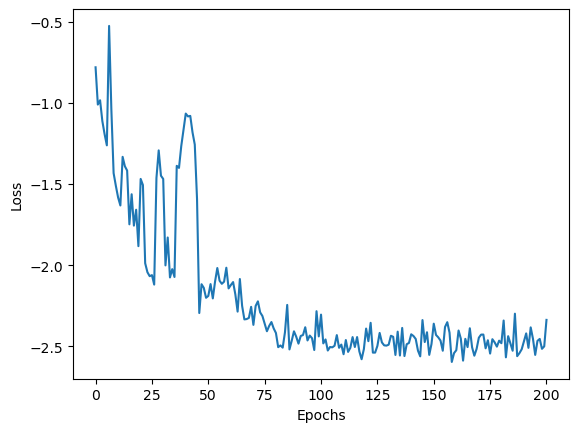

In [8]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [9]:
params

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.01794377],
       [1.8616167 ],
       [0.02403543]], dtype=float32)>

In [10]:
tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8618584>

In [11]:
tf.math.reduce_sum(params*np.array([[0],[1],[0]]))/tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99987024>

In [12]:
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('human_final.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Octopus

In [19]:

vertices, faces = off2numpy(r'Datasets/octopus.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0087004…

In [20]:
n_clusters=8
resolutions=np.array([10])
gain=np.array([0.3])
sigma=0.01

kmeans=KMeans(n_clusters=n_clusters,random_state=0)

params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-0, decay_steps=10, decay_rate=.05)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

In [21]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('octopus_initial.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [22]:
losses = []
K=10
with Parallel(n_jobs=-1) as parallel:
    for epoch in tqdm(range(200+1)):

        f=tf.tensordot(X,params,axes=1)
        fn=(f-tf.math.reduce_min(f))/(tf.math.reduce_max(f)-tf.math.reduce_min(f))
        scheme=smooth_scheme(fn.numpy(),resolutions,gain,sigma)

        upscheme=np.repeat(scheme,K,axis=0)

        assignments=bernoulli.rvs(upscheme,random_state=0)

        st,clusters=compute_mapper(X.numpy(),kmeans,assignments,maximum=8)
        
        with tf.GradientTape() as tape:
            f=tf.tensordot(X,params,axes=1)
            f_values=tf.repeat(tf.expand_dims(f,axis=0),clusters.shape[0],axis=0)

            f_values=tf.repeat(f_values,clusters.shape[2],axis=2)

            filtration=tf.math.reduce_sum(f_values*clusters,axis=1)/np.sum(clusters,axis=1)
            #l=[(_LowerStarSimplexTree(st[k],filtration[k],[0],11,False)[0][0]).reshape(-1,2) for k in range(n)]
            l=parallel(delayed(filter_st)(list(st[k].get_skeleton(1)),filtration.numpy()[k]) 
                for k in range(K))
            loss=0
            
            #dgm=tf.concat([tf.gather(filtration[k],l[k]) for k in range(K)],axis=0)
            for k in range(K):
                dgm=tf.gather(filtration[k],l[k]) 
                loss=loss-tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))/K

            regularization = tf.math.square(tf.norm(params)-1)

            loss=loss+regularization

        gradients = tape.gradient(loss, [params])
        
        optimizer.apply_gradients(zip(gradients, [params]))


        losses.append(loss.numpy())

100%|█████████████████████████████████████████| 201/201 [02:48<00:00,  1.19it/s]


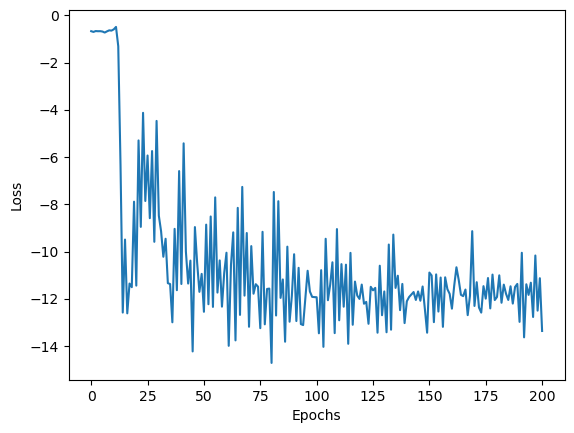

In [23]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [24]:
params

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.18035083],
       [ 0.11191036],
       [-3.7973974 ]], dtype=float32)>

In [25]:
tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8033245>

In [26]:
tf.math.reduce_sum(params*np.array([[0],[0],[1]]))/tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9984416>

In [27]:
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('octopus_final.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Table

In [28]:

vertices, faces = off2numpy(r'Datasets/table.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0083769…

In [29]:
pca = PCA(n_components=2)
pca.fit(vertices)
pca.components_

array([[ 9.99999801e-01,  1.38216285e-04,  6.15789146e-04],
       [-6.16025438e-04,  1.71610266e-03,  9.99998338e-01]])

In [30]:
n_clusters=8
resolutions=np.array([10])
gain=np.array([0.35])
sigma=0.01

kmeans=KMeans(n_clusters=n_clusters)

params=tf.Variable(initial_value=np.array([[1],[1],[1]]).astype(np.float32)/np.sqrt(3),trainable=True)
X=tf.Variable(initial_value=vertices.astype(np.float32), trainable=False)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.1)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

In [31]:
f=tf.tensordot(X,params,axes=1)
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('table2_initial.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [32]:
losses = []
K=10
with Parallel(n_jobs=-1) as parallel:
    for epoch in tqdm(range(200+1)):

        f=tf.tensordot(X,params,axes=1)
        fn=(f-tf.math.reduce_min(f))/(tf.math.reduce_max(f)-tf.math.reduce_min(f))
        scheme=smooth_scheme(fn.numpy(),resolutions,gain,sigma)

        upscheme=np.repeat(scheme,K,axis=0)

        assignments=bernoulli.rvs(upscheme)

        st,clusters=compute_mapper(X.numpy(),kmeans,assignments,maximum=8)
        
        with tf.GradientTape() as tape:
            f=tf.tensordot(X,params,axes=1)
            f_values=tf.repeat(tf.expand_dims(f,axis=0),clusters.shape[0],axis=0)

            f_values=tf.repeat(f_values,clusters.shape[2],axis=2)

            filtration=tf.math.reduce_sum(f_values*clusters,axis=1)/np.sum(clusters,axis=1)
            #l=[(_LowerStarSimplexTree(st[k],filtration[k],[0],11,False)[0][0]).reshape(-1,2) for k in range(n)]
            l=parallel(delayed(filter_st)(list(st[k].get_skeleton(1)),filtration.numpy()[k]) 
                for k in range(K))
            loss=0
            
            #dgm=tf.concat([tf.gather(filtration[k],l[k]) for k in range(K)],axis=0)
            for k in range(K):
                dgm=tf.gather(filtration[k],l[k]) 
                loss=loss-tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))/K

            regularization = tf.math.square(tf.norm(params)-1)

            loss=loss+regularization

        gradients = tape.gradient(loss, [params])
        
        optimizer.apply_gradients(zip(gradients, [params]))


        losses.append(loss.numpy())

100%|█████████████████████████████████████████| 201/201 [03:23<00:00,  1.01s/it]


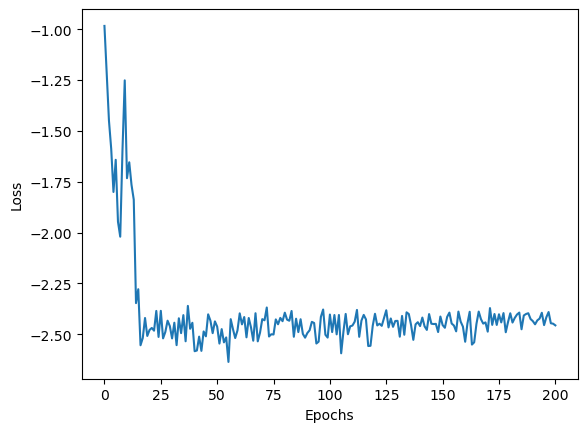

In [33]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [34]:
params

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-3.0332571e-03],
       [ 1.8564398e+00],
       [ 1.4509372e-03]], dtype=float32)>

In [35]:
tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8564429>

In [36]:
tf.math.reduce_sum(params*np.array([[0],[1],[0]]))/tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999833>

In [37]:
mapper=MapperComplex(colors=f.numpy(),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)
nt=mapper.get_pyvis()
nt.show('table2_final.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
